# How to use the `abscal` module of `hera_cal`
<br>
Jan. 2018
<br>
Nick Kern
<br>
nkern@berkeley.edu

---

In this tutorial, we show you one way you can use the absolute calibration capabilities of `hera_cal` to phase and scale data to an absolute reference. We use example data from HERA-47 observation, having extracted out a smaller sub-array from the data.

We do this both on data that has already had `omnical` calibration applied as well as on raw data.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import sys
from pyuvdata import UVData, UVCal
import hera_cal as hc
from hera_cal.data import DATA_PATH
from collections import OrderedDict as odict
from pyuvdata import utils as uvutils
import copy
import uvtools as uvt
import linsolve
from hera_cal.datacontainer import DataContainer

# Table of Contents

1. [Absolute Calibration of omnical'd data using constrained bandpass solvers](#Absolute-Calibration-of-omnical'd-data-using-constrained-bandpass-solvers)

1. [Absolute Calibration of raw data using general bandpass solvers](#Absolute-Calibration-of-raw-data-using-general-bandpass-solvers)

# Absolute Calibration of `omnical`'d data using constrained bandpass solvers

We start with data that has already been redundantly calibrated through `omnical`. We then select a model from a different night that has already been absolutely calibrated (using CASA and point source models) that lines up in LST with our data. We then use the ***constrained bandpass*** solvers in `hera_cal.abscal` to solve for the degenerate degrees of freedom missing in the `omnical` solution.

These constrained bandpass solvers are `abs_amp_lincal`, which solves for a single amplitude across all antennas that sets the flux scale, and `TT_phs_logcal`, which solves for the Tip-Tilt of the array and the overall phase scalar of the array.

In [13]:
# specify model file and load into UVData, load into dictionary
model_fname1 = os.path.join(DATA_PATH, "zen.2458042.12552.xx.HH.uvXA")
model_fname2 = os.path.join(DATA_PATH, "zen.2458042.13298.xx.HH.uvXA")
(model, mflags, antpos, ants, model_freqs, model_times, model_lsts,
 model_pols) = hc.io.load_vis([model_fname1, model_fname2], return_meta=True)

# specify data file and load into UVData, load into dictionary
data_fname = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
(data, dflags, antpos, ants, data_freqs, data_times, data_lsts, 
 data_pols) = hc.io.load_vis(data_fname, return_meta=True)

# make wgts
wgts = copy.deepcopy(dflags)
for k in wgts.keys():
    wgts[k] = (~wgts[k]).astype(np.float)

antloc = np.array(list(map(lambda k: antpos[k], ants)))
antloc -= np.median(antloc, axis=0)
bls = odict([(x, antpos[x[0]] - antpos[x[1]]) for x in model.keys()])

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(-30.0, 30.0)

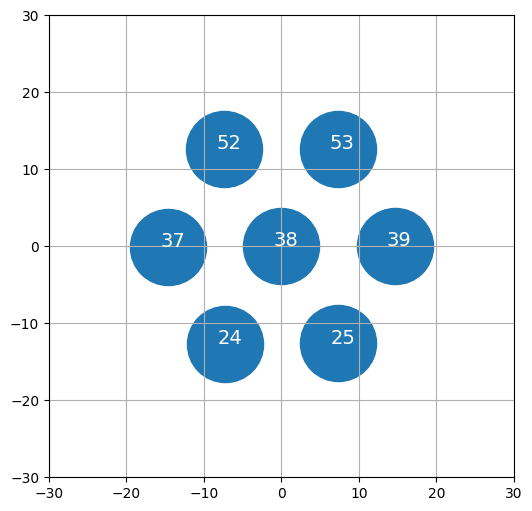

In [17]:
# plot sub-array HERA layout
plt.figure(figsize=(6,6))
plt.grid()
plt.scatter(antloc[:, 0], antloc[:, 1], s=3000)
_ = [plt.text(antloc[i, 0]-1, antloc[i, 1], str(ants[i]), fontsize=14, color='w') for i in range(len(ants))]
plt.xlim(-30, 30)
plt.ylim(-30, 30)

## interpolate model onto time & freq axes of data

In [20]:
print(len(model), len(model_lsts), len(model_freqs))

model, interp_flags = hc.abscal.interp2d_vis(model, model_lsts, model_freqs, data_lsts, data_freqs)

28 120 64


ValueError: x and y must have equal lengths for non rectangular grid

## Instantiate `AbsCal` object

In [ ]:
# instantiate class
AC = hc.abscal.AbsCal(model, data, antpos=antpos, wgts=wgts, freqs=data_freqs)

## plot model and data

Text(0.5,1,u"model PHS (24, 53, 'xx')")

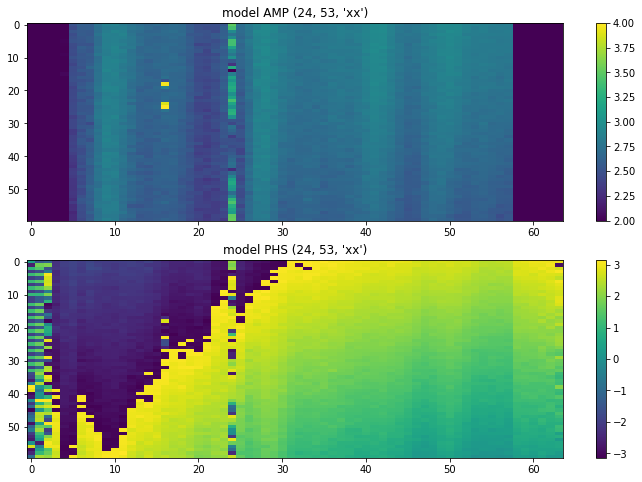

In [ ]:
# plot model
bl = (24, 53, 'xx')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plt.sca(axes[0])
uvt.plot.waterfall(AC.model[bl], mode='log', mx=4, drng=2)
plt.colorbar()
plt.title('model AMP {}'.format(bl))
plt.sca(axes[1])
uvt.plot.waterfall(AC.model[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('model PHS {}'.format(bl))

divide by zero encountered in log10


Text(0.5,1,u"data PHS (24, 53, 'xx')")

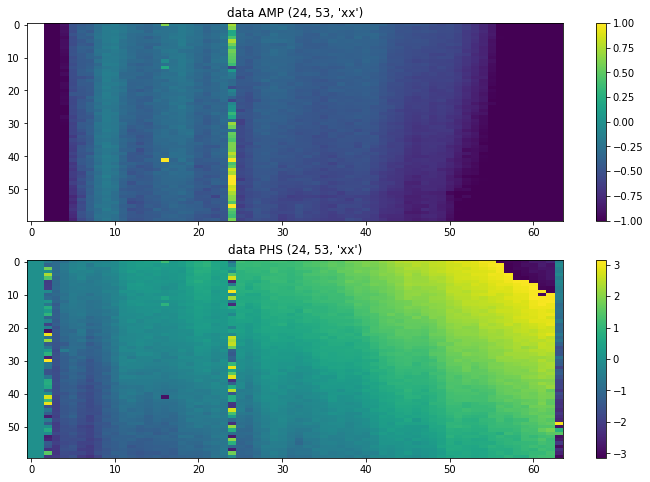

In [ ]:
# plot data
bl = (24, 53, 'xx')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plt.sca(axes[0])
uvt.plot.waterfall(AC.data[bl], mode='log', mx=1, drng=2)
plt.colorbar()
plt.title('data AMP {}'.format(bl))
plt.sca(axes[1])
uvt.plot.waterfall(AC.data[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('data PHS {}'.format(bl))

## run delay solver and inspect gains

In [ ]:
# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
AC.delay_slope_lincal(kernel=(1, 3), medfilt=True, time_avg=True)

...configuring linsolve data for delay_lincal
...running linsolve
...finished linsolve


(-0.3, 0.3)

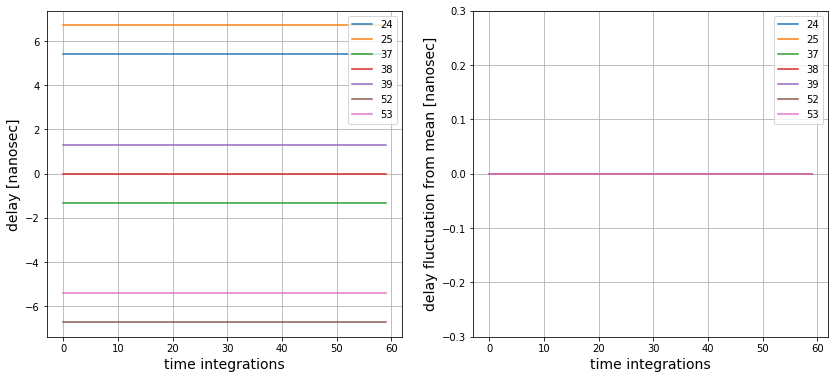

In [ ]:
# inspect delays
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax = axes[0]
ax.grid()
dlys = AC.dly_slope_ant_dly_arr[:, :, 0, 0].T * 1e9
pl = ax.plot(dlys)
ax.legend(pl, AC.ants)
ax.set_xlabel('time integrations', fontsize=14)
ax.set_ylabel('delay [nanosec]', fontsize=14)

ax = axes[1]
ax.grid()
mean_dly = np.median(dlys, axis=0)
pl = ax.plot(dlys - mean_dly)
ax.legend(pl, AC.ants)
ax.set_xlabel('time integrations', fontsize=14)
ax.set_ylabel('delay fluctuation from mean [nanosec]', fontsize=14)
ax.set_ylim(-0.3, 0.3)

In [ ]:
# apply to data
delay_corr_data = hc.abscal.apply_gains(AC.data, (AC.dly_slope_gain))

Text(0.5,1,u"data-corrected PHS (25, 38, 'xx')")

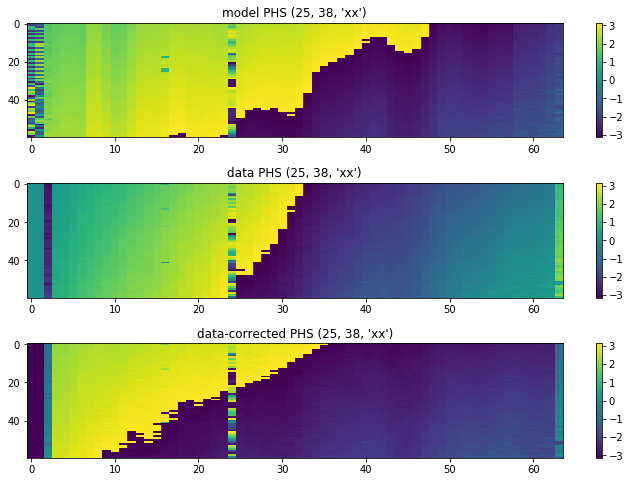

In [ ]:
# inspect results data
bl = (25, 38, 'xx')
fig, axes = plt.subplots(3, 1, figsize=(12, 8))
fig.subplots_adjust(hspace=0.4)

plt.sca(axes[0])
uvt.plot.waterfall(model[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('model PHS {}'.format(bl))

plt.sca(axes[1])
uvt.plot.waterfall(data[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('data PHS {}'.format(bl))

plt.sca(axes[2])
uvt.plot.waterfall(delay_corr_data[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('data-corrected PHS {}'.format(bl))

## reinstantiate `AbsCal` with delay-corrected data

In [ ]:
# instantiate class
DAC = hc.abscal.AbsCal(model, delay_corr_data, antpos=antpos, wgts=wgts, freqs=data_freqs)

## run average phase solver

In [ ]:
# avg phase solver
DAC.phs_logcal(avg=True)

...configuring linsolve data for phs_logcal
...running linsolve
...finished linsolve


## apply to data

In [ ]:
# apply to data
dly_phs_corr_data = hc.abscal.apply_gains(DAC.data, (DAC.ant_phi_gain))

Text(0.5,1,u"data-corrected PHS (25, 38, 'xx')")

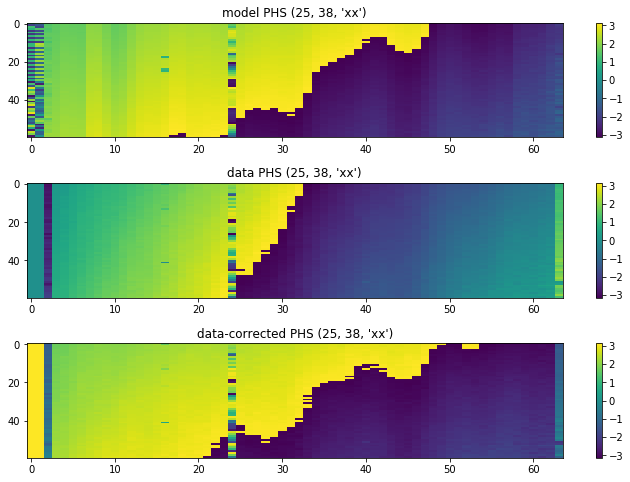

In [ ]:
# inspect results data
bl = (25, 38, 'xx')
fig, axes = plt.subplots(3, 1, figsize=(12, 8))
fig.subplots_adjust(hspace=0.4)

plt.sca(axes[0])
uvt.plot.waterfall(model[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('model PHS {}'.format(bl))

plt.sca(axes[1])
uvt.plot.waterfall(data[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('data PHS {}'.format(bl))

plt.sca(axes[2])
uvt.plot.waterfall(dly_phs_corr_data[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('data-corrected PHS {}'.format(bl))

## reinstantiate class with delay + avg_phase corrected data

In [ ]:
# instantiate class
DPAC = hc.abscal.AbsCal(model, dly_phs_corr_data, antpos=antpos, wgts=wgts, freqs=data_freqs)

## run absolute amplitude solver

In [ ]:
# run amp linsolve
DPAC.abs_amp_logcal()

...configuring linsolve data for abs_amp_logcal
...running linsolve


divide by zero encountered in log


...finished linsolve


Text(0,0.5,u'absolute $\\eta$')

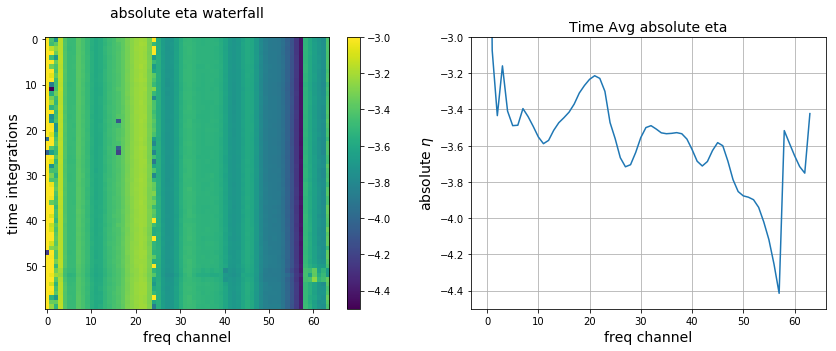

In [ ]:
# inspect absolute scalar results
# plot gain amp
fig, axes = plt.subplots(1, 2, figsize=(14,5))

ax = axes[0]
cax = ax.matshow(DPAC.abs_eta_arr[0,:,:,0], aspect='auto', vmin=-4.5, vmax=-3)
fig.colorbar(cax, ax=ax)
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('freq channel', fontsize=14)
ax.set_ylabel('time integrations', fontsize=14)
ax.set_title('absolute eta waterfall', fontsize=14)

ax = axes[1]
ax.plot(np.median(DPAC.abs_eta_arr[0,:,:,0], axis=0))
ax.grid()
ax.set_xlabel('freq channel', fontsize=14)
ax.set_title('Time Avg absolute eta', fontsize=14)
ax.set_ylim(-4.5, -3)
ax.set_ylabel(r'absolute $\eta$', fontsize=14)

## run tip-tilt phase solver

In [ ]:
# run phs linsolve
DPAC.TT_phs_logcal(zero_psi=False, four_pol=False)

...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve


### plot overall phase

Text(0,0.5,u'overall phase [radian]')

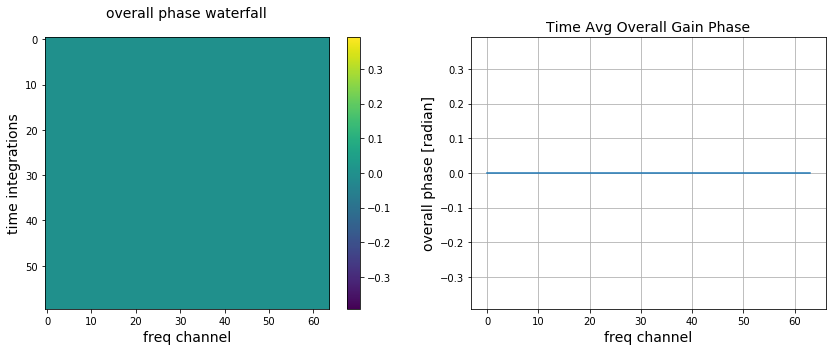

In [ ]:
# plot psi
fig, axes = plt.subplots(1, 2, figsize=(14,5))

ax = axes[0]
cax = ax.matshow(DPAC.abs_psi_arr[0, :, :, 0], aspect='auto', vmin=-np.pi/8, vmax=np.pi/8)
fig.colorbar(cax, ax=ax)
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('freq channel', fontsize=14)
ax.set_ylabel('time integrations', fontsize=14)
ax.set_title('overall phase waterfall', fontsize=14)

ax = axes[1]
ax.plot(np.median(DPAC.abs_psi_arr[0, :, :, 0], axis=0))
ax.grid()
ax.set_xlabel('freq channel', fontsize=14)
ax.set_title('Time Avg Overall Gain Phase', fontsize=14)
ax.set_ylim(-np.pi/8, np.pi/8)
ax.set_ylabel('overall phase [radian]', fontsize=14)

### inspect tip-tilt phase

(-0.05, 0.05)

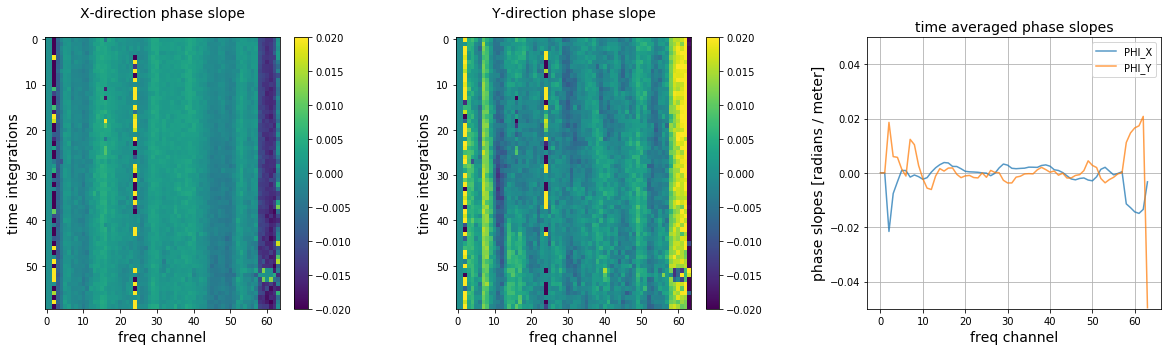

In [ ]:
# plot gain phi
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.subplots_adjust(wspace=0.4)

ax = axes[0]
cax = ax.matshow(DPAC.TT_Phi_arr[0, 0, :, :, 0], aspect='auto', vmin=-.02, vmax=0.02)
fig.colorbar(cax, ax=ax)
ax.set_title('PHI_X')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('freq channel', fontsize=14)
ax.set_ylabel('time integrations', fontsize=14)
ax.set_title('X-direction phase slope', fontsize=14)

ax = axes[1]
cax = ax.matshow(DPAC.TT_Phi_arr[0, 1, :, :, 0], aspect='auto', vmin=-.02, vmax=0.02)
fig.colorbar(cax, ax=ax)
ax.set_title('PHI_Y')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('freq channel', fontsize=14)
ax.set_ylabel('time integrations', fontsize=14)
ax.set_title('Y-direction phase slope', fontsize=14)

ax = axes[2]
p0, = ax.plot(np.nanmedian(DPAC.TT_Phi_arr[0, 0, :, :, 0], axis=0), alpha=0.75)
p1, = ax.plot(np.nanmedian(DPAC.TT_Phi_arr[0, 1, :, :, 0], axis=0), alpha=0.75)
ax.grid()
ax.set_xlabel('freq channel', fontsize=14)
ax.set_title('time averaged phase slopes', fontsize=14)
ax.set_ylabel('phase slopes [radians / meter]', fontsize=14)
ax.legend([p0,p1], ["PHI_X", "PHI_Y"])
ax.set_ylim(-.05, .05)

In [ ]:
# apply to data
abs_corr_data = hc.abscal.apply_gains(DPAC.data, (DPAC.abs_psi_gain, 
                                                  DPAC.TT_Phi_gain, 
                                                  DPAC.abs_eta_gain), gain_convention='divide')

Text(0.5,1,u"data-corrected AMP (38, 53, 'xx')")

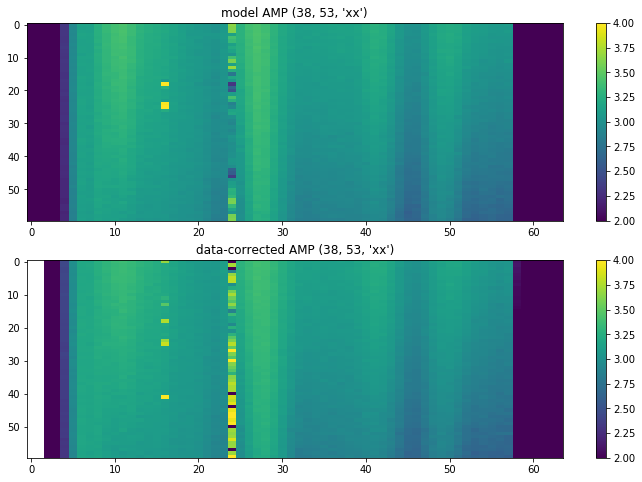

In [ ]:
# plot model and data-corrected amplitude
bl = (38, 53, 'xx')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plt.sca(axes[0])
uvt.plot.waterfall(model[bl], mode='log', mx=4, drng=2)
plt.colorbar()
plt.title('model AMP {}'.format(bl))

plt.sca(axes[1])
uvt.plot.waterfall(abs_corr_data[bl], mode='log', mx=4, drng=2)
plt.colorbar()
plt.title('data-corrected AMP {}'.format(bl))

Text(0.5,1,u"data-corrected PHS (38, 52, 'xx')")

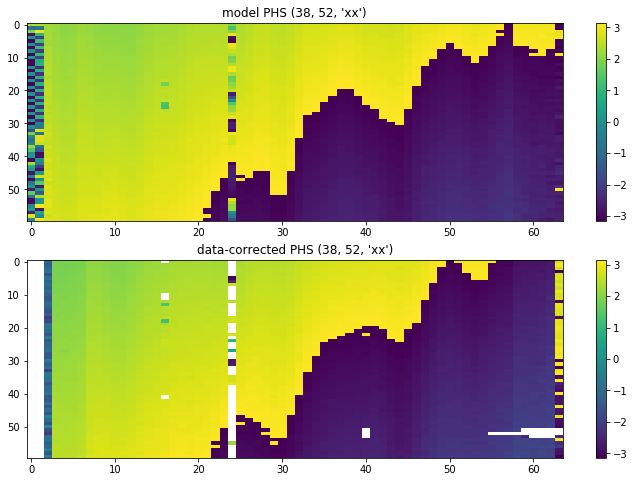

In [ ]:
# plot model and data-corrected phase
bl = (38, 52, 'xx')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plt.sca(axes[0])
uvt.plot.waterfall(model[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('model PHS {}'.format(bl))

plt.sca(axes[1])
d = abs_corr_data[bl]
d[~wgts[bl].astype(np.bool)] *= np.nan
uvt.plot.waterfall(d, mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('data-corrected PHS {}'.format(bl))

# Absolute Calibration of raw data using general bandpass solvers

This is essentially identical to our procedure before, but this time we start with raw data (rather than `omnical`'d data), and also we use the general bandpass solvers `amp_logcal` and `phs_logcal`, rather than the constrained bandpass solvers.

In [ ]:
# specify model file and load into UVData, load into dictionary
model_fname1 = os.path.join(DATA_PATH, "zen.2458042.12552.xx.HH.uvXA")
model_fname2 = os.path.join(DATA_PATH, "zen.2458042.13298.xx.HH.uvXA")
(model, mflags, antpos, ants, model_freqs, model_times, model_lsts,
 model_pols) = hc.io.load_vis([model_fname1, model_fname2], return_meta=True)

# specify data file and load into UVData, load into dictionary
data_fname = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvA")
(data, dflags, antpos, ants, data_freqs, data_times, data_lsts,
 data_pols) = hc.io.load_vis(data_fname, return_meta=True)

# make wgts
wgts = copy.deepcopy(dflags)
for k in wgts.keys():
    wgts[k] = (~wgts[k]).astype(np.float)

antloc = np.array(map(lambda k: antpos[k], ants))

In [ ]:
model, interp_flags = hc.abscal.interp2d_vis(model, model_lsts, model_freqs, data_lsts, data_freqs)

In [ ]:
# instantiate class
AC = hc.abscal.AbsCal(model, data, antpos=antpos, wgts=wgts, freqs=data_freqs)

Text(0.5,1,u"model PHS (24, 25, 'xx')")

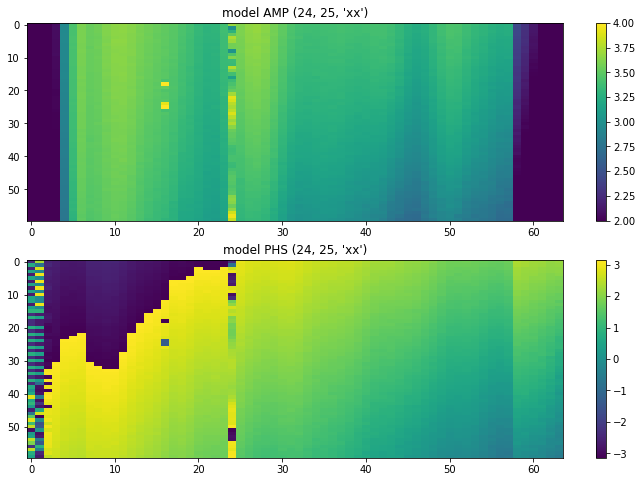

In [ ]:
# plot model
bl = (24, 25, 'xx')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plt.sca(axes[0])
uvt.plot.waterfall(AC.model[bl], mode='log', mx=4, drng=2)
plt.colorbar()
plt.title('model AMP {}'.format(bl))
plt.sca(axes[1])
uvt.plot.waterfall(AC.model[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('model PHS {}'.format(bl))

Text(0.5,1,u"data PHS (24, 25, 'xx')")

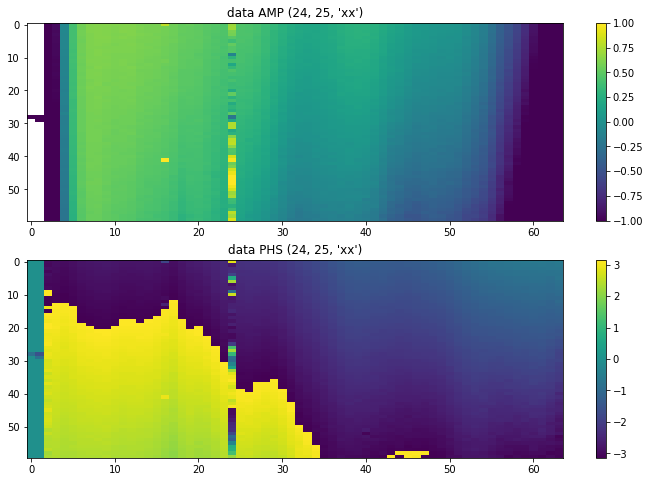

In [ ]:
# plot data
bl = (24, 25, 'xx')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plt.sca(axes[0])
uvt.plot.waterfall(AC.data[bl], mode='log', mx=1, drng=2)
plt.colorbar()
plt.title('data AMP {}'.format(bl))
plt.sca(axes[1])
uvt.plot.waterfall(AC.data[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('data PHS {}'.format(bl))

In [ ]:
AC.delay_lincal(time_avg=True, medfilt=True, solve_offsets=True)

...configuring linsolve data for delay_lincal
...running linsolve
...finished linsolve
...running linsolve
...finished linsolve


(-0.2, 0.2)

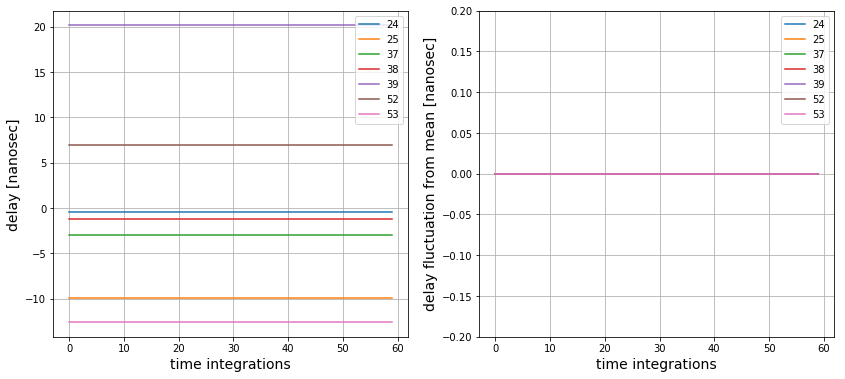

In [ ]:
# inspect delays
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax = axes[0]
ax.grid()
dlys = AC.ant_dly_arr[:, :, 0, 0].T * 1e9
pl = ax.plot(dlys)
ax.legend(pl, AC.ants)
ax.set_xlabel('time integrations', fontsize=14)
ax.set_ylabel('delay [nanosec]', fontsize=14)

ax = axes[1]
ax.grid()
mean_dly = np.median(dlys, axis=0)
pl = ax.plot(dlys - mean_dly)
ax.legend(pl, AC.ants)
ax.set_xlabel('time integrations', fontsize=14)
ax.set_ylabel('delay fluctuation from mean [nanosec]', fontsize=14)
ax.set_ylim(-0.2, 0.2)

In [ ]:
# apply to data
delay_corr_data = hc.abscal.apply_gains(AC.data, (AC.ant_dly_gain, AC.ant_dly_phi_gain))

Text(0.5,1,u"data-corrected PHS (38, 52, 'xx')")

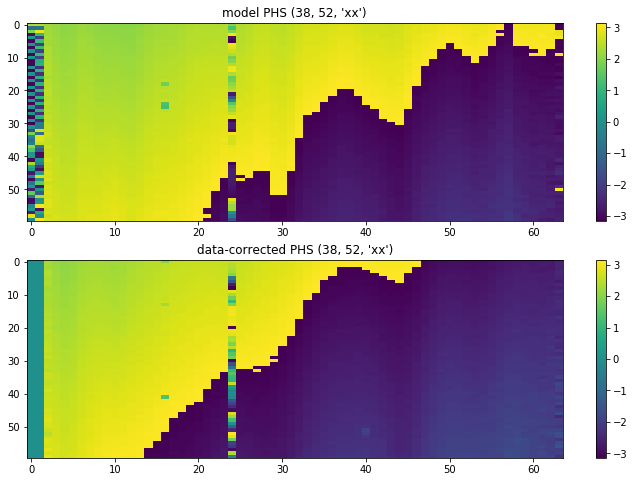

In [ ]:
### plot model and data-corrected phase
bl = (38, 52, 'xx')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plt.sca(axes[0])
uvt.plot.waterfall(AC.model[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('model PHS {}'.format(bl))

plt.sca(axes[1])
uvt.plot.waterfall(delay_corr_data[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('data-corrected PHS {}'.format(bl))

In [ ]:
# instantiate class
DAC = hc.abscal.AbsCal(AC.model, delay_corr_data, antpos=antpos, wgts=wgts, freqs=data_freqs)

In [ ]:
# run avg phase calibration
DAC.phs_logcal(avg=True)

...configuring linsolve data for phs_logcal
...running linsolve
...finished linsolve


In [ ]:
# apply to data
dly_phs_corr_data = hc.abscal.apply_gains(DAC.data, (DAC.ant_phi_gain))

Text(0.5,1,u"data-corrected PHS (38, 52, 'xx')")

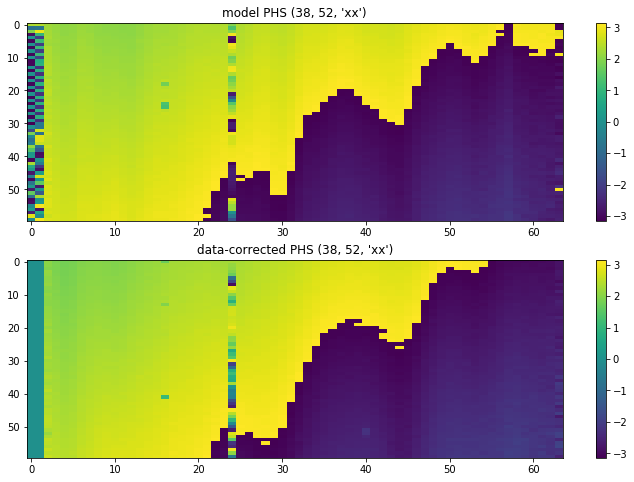

In [ ]:
### plot model and data-corrected phase
bl = (38, 52, 'xx')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plt.sca(axes[0])
uvt.plot.waterfall(AC.model[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('model PHS {}'.format(bl))

plt.sca(axes[1])
uvt.plot.waterfall(dly_phs_corr_data[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('data-corrected PHS {}'.format(bl))

In [ ]:
# instantiate class
DPAC = hc.abscal.AbsCal(DAC.model, dly_phs_corr_data, antpos=antpos, wgts=wgts, freqs=data_freqs)

In [ ]:
# run amp logcal
DPAC.amp_logcal()

...configuring linsolve data for amp_logcal
...running linsolve


divide by zero encountered in log


...finished linsolve


In [ ]:
# run phase calibration
DPAC.phs_logcal()

...configuring linsolve data for phs_logcal
...running linsolve
...finished linsolve


In [ ]:
# apply to data
abs_corr_data = hc.abscal.apply_gains(DPAC.data, (DPAC.ant_eta_gain, DPAC.ant_phi_gain))

Text(0.5,1,u"data-corrected AMP (38, 52, 'xx')")

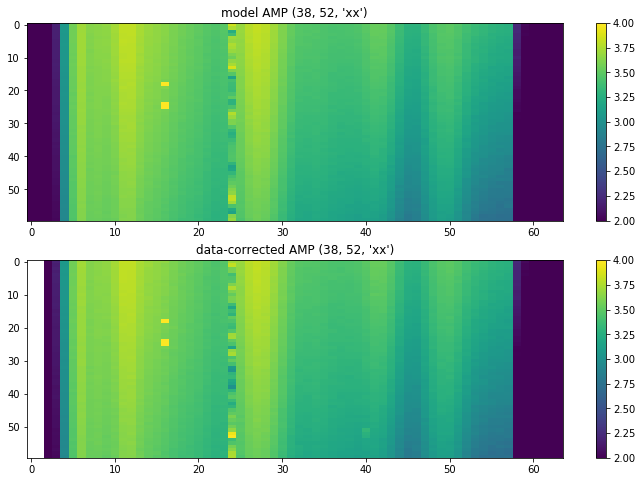

In [ ]:
# plot model and data-corrected amplitude
bl = (38, 52, 'xx')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plt.sca(axes[0])
uvt.plot.waterfall(DAC.model[bl], mode='log', mx=4, drng=2)
plt.colorbar()
plt.title('model AMP {}'.format(bl))

plt.sca(axes[1])
uvt.plot.waterfall(abs_corr_data[bl], mode='log', mx=4, drng=2)
plt.colorbar()
plt.title('data-corrected AMP {}'.format(bl))

Text(0.5,1,u"data-corrected PHS (38, 52, 'xx')")

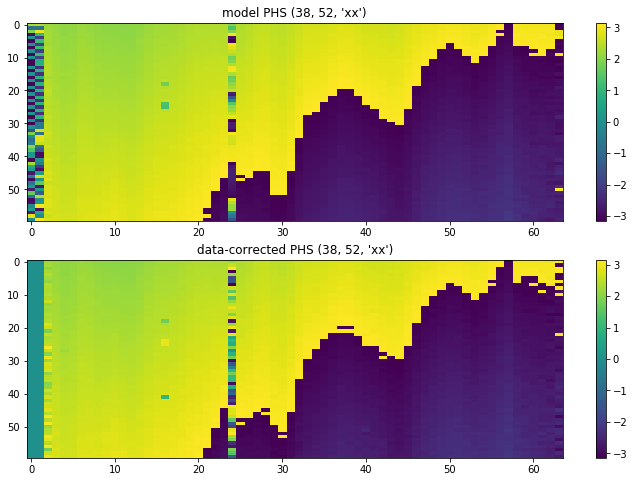

In [ ]:
# plot model and data-corrected phase
bl = (38, 52, 'xx')
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plt.sca(axes[0])
uvt.plot.waterfall(DAC.model[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('model PHS {}'.format(bl))

plt.sca(axes[1])
uvt.plot.waterfall(abs_corr_data[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('data-corrected PHS {}'.format(bl))

# Absolute Calibration of omnical model visibilities

In [ ]:
# load data
model_fname1 = os.path.join(DATA_PATH, 'zen.2458042.12552.xx.HH.uvXA')
model_fname2 = os.path.join(DATA_PATH, 'zen.2458042.13298.xx.HH.uvXA')
(model, mflags, mantpos, mants, mfreqs, mtimes, mlsts,
    mpols) = hc.io.load_vis([model_fname1, model_fname2], return_meta=True)
mantloc = np.array(mantpos.values())
mantloc -= np.median(mantloc, axis=0)

data_fname = os.path.join(DATA_PATH, 'zen.2458043.12552.xx.HH.uvA.vis.uvfits')
(data, dflags, dantpos, dants, dfreqs, dtimes, dlsts,
    dpols) = hc.io.load_vis(data_fname, return_meta=True)
wgts = DataContainer(odict(map(lambda k: (k, (~dflags[k]).astype(np.float)), dflags.keys())))
dantloc = np.array(dantpos.values())
dantloc -= np.median(dantloc, axis=0)

In [ ]:
# plot antennas
fig, axes = plt.subplots(1, 2, figsize=(10,5))

ax = axes[0]
ax.grid()
ax.scatter(mantloc[:, 0], mantloc[:,1], s=2000)
_ = [ax.text(mantloc[i,0], mantloc[i,1], mants[i], color='w', size=15) for i in range(len(mants))]
ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)
ax.set_title('model antenna positions')

ax = axes[1]
ax.grid()
ax.scatter(dantloc[:, 0], dantloc[:,1], s=2000)
_ = [ax.text(dantloc[i,0], dantloc[i,1], dants[i], color='w', size=15) for i in range(len(dants))]
ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)
ax.set_title('data antenna positions')

In [ ]:
# match model antennas to data antennas
model = hc.abscal.match_red_baselines(model, mantpos, data, dantpos, tol=1.0, verbose=True)

In [ ]:
# interpolate model times onto data times
model, mflags = hc.abscal.interp2d_vis(model, mlsts, mfreqs, dlsts, dfreqs, kind='cubic')

In [ ]:
# reweight weights 
wgts = hc.abscal.mirror_data_to_red_bls(wgts, dantpos, tol=1.0, weights=True)

In [ ]:
# instantiate AbsCal
AC = hc.abscal.AbsCal(model, data, wgts=wgts, antpos=dantpos, freqs=dfreqs)

In [ ]:
# plot model and data-corrected amplitude
bl = (0, 11, 'xx')
fig, axes = plt.subplots(4, 1, figsize=(15, 16))

plt.sca(axes[0])
uvt.plot.waterfall(AC.model[bl], mode='log', mx=4, drng=2)
plt.colorbar()
plt.title('model AMP {}'.format(bl))

plt.sca(axes[1])
uvt.plot.waterfall(AC.data[bl], mode='log', mx=4, drng=2)
plt.colorbar()
plt.title('data AMP {}'.format(bl))

plt.sca(axes[2])
uvt.plot.waterfall(AC.model[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('model PHS {}'.format(bl))

plt.sca(axes[3])
uvt.plot.waterfall(AC.data[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('data PHS {}'.format(bl))

In [ ]:
# run delay slope cal
AC.delay_slope_lincal(medfilt=True, time_avg=True)

In [ ]:
# inspect delays
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax = axes[0]
ax.grid()
dlys = AC.dly_slope_ant_dly_arr[:, :, 0, 0].T * 1e9
pl = ax.plot(dlys)
ax.legend(pl, AC.ants)
ax.set_xlabel('time integrations', fontsize=14)
ax.set_ylabel('delay [nanosec]', fontsize=14)

ax = axes[1]
ax.grid()
mean_dly = np.median(dlys, axis=0)
pl = ax.plot(dlys - mean_dly)
ax.legend(pl, AC.ants)
ax.set_xlabel('time integrations', fontsize=14)
ax.set_ylabel('delay fluctuation from mean [nanosec]', fontsize=14)
ax.set_ylim(-0.2, 0.2)

In [ ]:
# apply gains to data
delay_corr_data = hc.abscal.apply_gains(AC.data, AC.dly_slope_gain)

In [ ]:
# reinstantiate object w/ delay corrected data
DAC = hc.abscal.AbsCal(AC.model, delay_corr_data, wgts=wgts, antpos=dantpos, freqs=dfreqs)

In [ ]:
# plot model and data-corrected amplitude
bl = (0, 11, 'xx')
fig, axes = plt.subplots(4, 1, figsize=(15, 16))

plt.sca(axes[0])
uvt.plot.waterfall(DAC.model[bl], mode='log', mx=4, drng=2)
plt.colorbar()
plt.title('model AMP {}'.format(bl))

plt.sca(axes[1])
uvt.plot.waterfall(DAC.data[bl], mode='log', mx=4, drng=2)
plt.colorbar()
plt.title('data AMP {}'.format(bl))

plt.sca(axes[2])
uvt.plot.waterfall(DAC.model[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('model PHS {}'.format(bl))

plt.sca(axes[3])
uvt.plot.waterfall(DAC.data[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('data-corrected PHS {}'.format(bl))

In [ ]:
# run abs amp and TT_phase cal
DAC.abs_amp_logcal()
DAC.TT_phs_logcal()

In [ ]:
# create new abs_corr_data
abs_corr_data = hc.abscal.apply_gains(DAC.data, (DAC.abs_eta_gain, DAC.TT_Phi_gain))

In [ ]:
# plot model and data-corrected amplitude
bl = (0, 11, 'xx')
fig, axes = plt.subplots(4, 1, figsize=(15, 16))

plt.sca(axes[0])
uvt.plot.waterfall(DAC.model[bl], mode='log', mx=4, drng=2)
plt.colorbar()
plt.title('model AMP {}'.format(bl))

plt.sca(axes[1])
uvt.plot.waterfall(abs_corr_data[bl], mode='log', mx=4, drng=2)
plt.colorbar()
plt.title('data-corrected AMP {}'.format(bl))

plt.sca(axes[2])
uvt.plot.waterfall(DAC.model[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('model PHS {}'.format(bl))

plt.sca(axes[3])
uvt.plot.waterfall(abs_corr_data[bl], mode='phs', mx=np.pi, drng=2*np.pi)
plt.colorbar()
plt.title('data-corrected PHS {}'.format(bl))

In [ ]:
# create gain keys for all antennas
(data, dflags, dantpos, dants, dfreqs, dtimes, dlsts,
    dpols) = hc.abscal.UVData2AbsCalDict(data_fname, return_meta=True, pick_data_ants=False)
pols = np.array(map(lambda p: AC.pol2str[p], dpols))
gain_keys = hc.abscal.flatten(map(lambda p: map(lambda k: (k, p), dants), AC.gain_pols))

In [ ]:
# create full gains for all antennas
dly_gains = AC.custom_dly_slope_gain(gain_keys, dantpos)
abs_eta_gains = DAC.custom_abs_eta_gain(gain_keys)
TT_Phi_gains= DAC.custom_TT_Phi_gain(gain_keys, dantpos)

gains = hc.abscal.merge_gains((dly_gains, abs_eta_gains, TT_Phi_gains))

In [ ]:
# write to file
hc.abscal.gains2calfits("example_abs.calfits", gains, dfreqs, dtimes, AC.gain_pols)

In [ ]:
os.remove('example_abs.calfits')